# **Visualization - How Does BERT Answer Questions?**
In this notebook, we will carry out the following badges:

1.   Replicate the visualization for the bert architecture:
  *   Visualize hidden states of Bert finetuned on Squad and Biba

In [9]:
%load_ext autoreload
%autoreload 2
import json
import torch
import numpy as np
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, AutoConfig

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **1. Load pretrained models (Squad, Biba (In second part)) and prepare the samples**
The models are from the paper, which are more or less equal to the ones one can find in the pretrained section of the transformers lib.
<img src="http://mccormickml.com/assets/BERT/SQuAD/input_formatting.png" alt="How QA works in Bert" width="500"/>

In [138]:
tokenizer_bert_squad = AutoTokenizer.from_pretrained("bert-base-uncased")

config = AutoConfig.from_pretrained(
            "bert-base-uncased", output_hidden_states=True, cache_dir="../cache"
        )
pretrained_weights = torch.load(
                "../models/squad.bin", map_location=torch.device("cpu")
        )
model_bert_squad = AutoModelForQuestionAnswering.from_pretrained(
        "../models/squad.bin",
        state_dict=pretrained_weights,
        config=config,
        cache_dir="../cache",
)

In [139]:
# Prepare squad sample
sample = json.load(open("./visualization/samples/sample_paper_squad.json"))# QASample.from_json_file("./visualization/samples/sample_paper_squad.json")
features = tokenizer_bert_squad.encode_plus(sample['question'], sample['context'], return_tensors='pt')
tokens = tokenizer_bert_squad.convert_ids_to_tokens(features['input_ids'][0])
print(features, tokens)

{'input_ids': tensor([[  101,  2054,  2003,  1037,  2691,  7750,  1999,  1996,  2866,  1998,
          3163,  1029,   102,  2747, 12345,  2003,  2028,  1997,  1996,  2087,
          2691, 26136,  1011,  2003, 14227, 11187,  1999,  2816,  1999,  1996,
          2142,  2163,  1010,  1996,  2866,  1010, 20868,  2063,  1011,  2455,
          1010,  5264,  1998,  2060,  3032,  1012,  2009,  5942,  1996, 11136,
          2000,  3961,  1999,  2082,  2012,  1037,  2445,  2051,  1999,  1996,
          2082,  2154,  1006,  2107,  2004,  6265,  1010, 28290,  2030,  2044,
          2082,  1007,  1025,  2030,  2130,  2000,  5463,  2082,  2006,  1037,
          2512,  1011,  2082,  2154,  1010,  1041,  1012,  1043,  1012,  1005,
          5095, 12345,  1005,  2218,  2012,  2070,  2816,  1012,  2076, 12345,
          1010,  2493,  5373,  2031,  2000,  4133,  1999,  1037,  9823,  1998,
          2079,  2147,  1010,  4339,  3210,  2030,  1037,  7750,  9491,  1010,
          2030,  4133,  5168,  1012,  

## **2. Generate Answer and get Answer, Question and Support Facts Ranges for visualization**

In [142]:
# Generate answer and get hidden states
outs = model_bert_squad(
                features["input_ids"],
                token_type_ids=features["token_type_ids"],
                attention_mask=features["attention_mask"]
            )
answer_start = torch.argmax(outs.start_logits)
answer_end = torch.argmax(outs.end_logits)
answer = ' '.join(tokens[answer_start:answer_end+1])
answer_ids = tokenizer_bert_squad.encode(answer, add_special_tokens=False, return_tensors='pt')
hstates = outs.hidden_states

print(answer, answer_ids)


detention tensor([[12345]])


In [132]:
from nltk import tokenize
# get token ids for answer/question/supporting facts
ids = features["input_ids"][0].int().numpy()
answer_index = [np.where(ids==id.numpy())[0][0] for id in answer_ids[0]] # get only the first occurence of the answer.

# question index range
question_end_index = [i for i, e in enumerate(tokens) if '[SEP]' in e][0]
question_index_range = [1, question_end_index] # skip cls token

# support fact index range for squad sample
sentences =  tokenize.sent_tokenize(sample['context'])
support_sentence = [s for s in sentences if answer in s][0]
sup_sent_ids = tokenizer_bert_squad(support_sentence, add_special_tokens=False, return_tensors='pt')['input_ids'][0].numpy() # remove end token
sup_start = [x for x in range(len(ids)) if np.all(ids[x:x+len(sup_sent_ids)] == sup_sent_ids)][0]
support_facts_range = [sup_start, sup_start+len(sup_sent_ids)-1]

print(tokens[question_index_range[0]:question_index_range[1]])
print(tokens[support_facts_range[0]:support_facts_range[1]])
print(tokens[answer_index[0]])

['what', 'is', 'a', 'common', 'punishment', 'in', 'the', 'uk', 'and', 'ireland', '?']
['currently', 'detention', 'is', 'one', 'of', 'the', 'most', 'common', 'pun', '-', 'is', '##hm', '##ents', 'in', 'schools', 'in', 'the', 'united', 'states', ',', 'the', 'uk', ',', 'ir', '##e', '-', 'land', ',', 'singapore', 'and', 'other', 'countries', '.']
detention


<ipython-input-132-7a34d7d27ab2>:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  sup_start = [x for x in range(len(ids)) if np.all(ids[x:x+len(sup_sent_ids)] == sup_sent_ids)][0]


## **3. Visualize the Hidden States using PCA**

In [111]:
# helper methods for plotting

from enum import Enum
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

class TokenLabel(Enum):
    PREDICTION = "d", "red"
    SUP = "o", "green"
    QUESTION = "o", "cyan"
    DEFAULT = "o", "grey"

class TokenInfo():

    def __init__(self, x, y, token, label):
        self.x = x
        self.y = y
        self.token = token
        self.label = label

def plot_hidden_state(token_vector, title):
    for token in token_vector:
        plt.scatter(token.x, token.y, c=token.label.value[1], marker=token.label.value[0])
        plt.text(token.x + 0.1, token.y + 0.2, token.token, fontsize=6)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title(title)
    plt.show()

def visualize_states(hstates, answer, question, sup_facts):
    for index, layer in enumerate(hstates):
        token_vectors = layer[0][:len(tokens)]
        reduction = PCA(n_components=2)
        layer_reduced = reduction.fit_transform(token_vectors.detach().numpy()).transpose()

        token_vectors = []
        for token_index, value in enumerate(layer_reduced[0]):
            label = TokenLabel.DEFAULT
            is_supporting_fact_token = False
            if sup_facts[0] <= token_index <= sup_facts[1]:
                label = TokenLabel.SUP
            if token_index in answer:
                label = TokenLabel.PREDICTION
            elif token_index >= question[0] and token_index <= question[1]:
                label = TokenLabel.QUESTION

            token_vector = TokenInfo(
                                x=value,
                                y=layer_reduced[1][token_index],
                                token=tokens[token_index],
                                label=label
                                )
            token_vectors.append(token_vector)
        title = "Layer {}".format(index)
        plot_hidden_state(token_vectors, title)

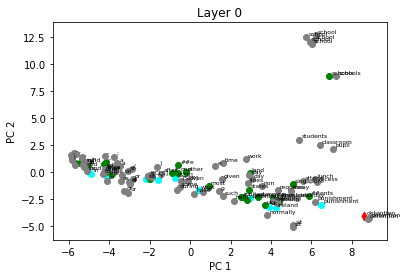

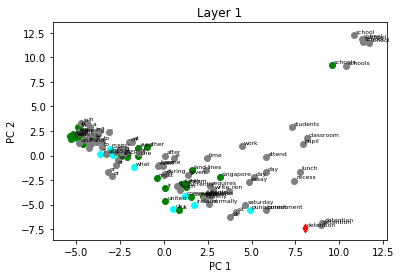

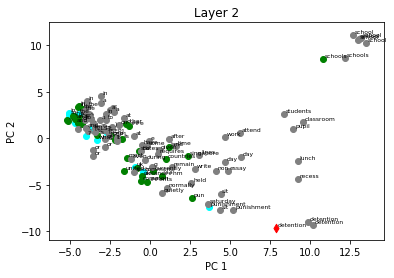

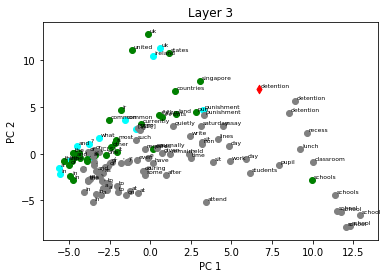

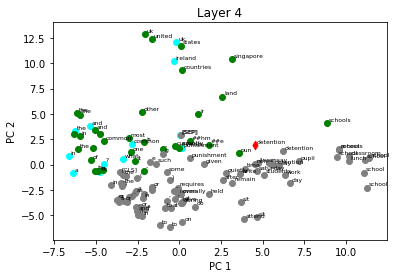

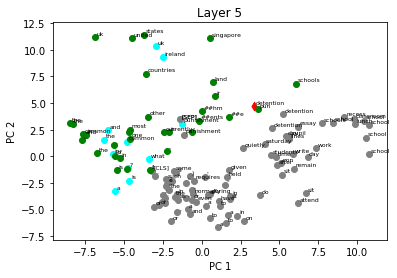

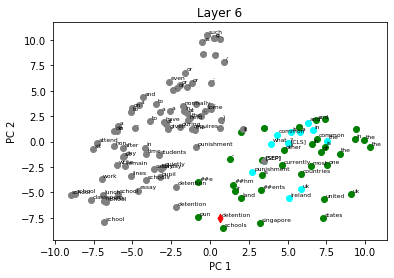

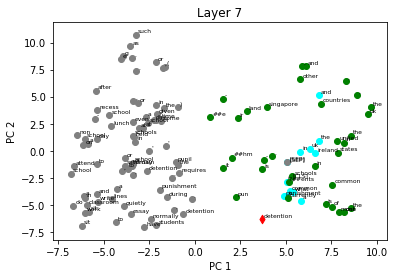

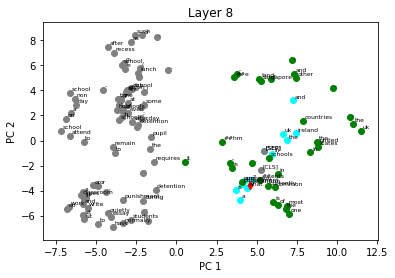

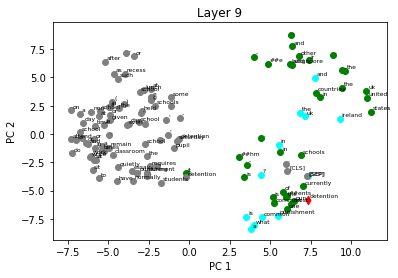

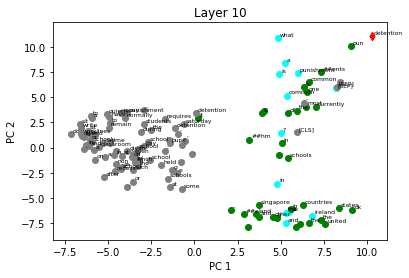

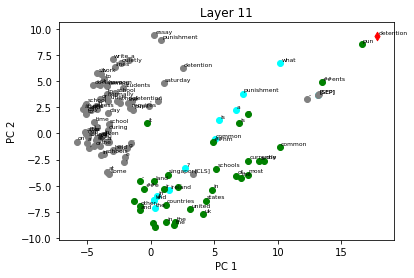

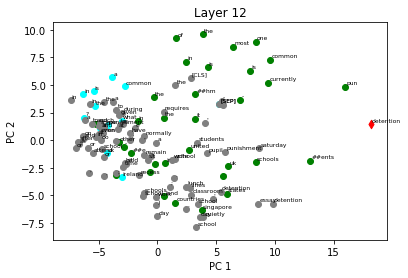

In [112]:
visualize_states(hstates, answer_index, question_index_range, support_facts_range)

## **4. Do (basically) the same for the biba sample**

In [143]:
tokenizer_bert_babi = AutoTokenizer.from_pretrained("bert-base-uncased")

config = AutoConfig.from_pretrained(
            "bert-base-uncased", output_hidden_states=True, cache_dir="../cache"
        )
pretrained_weights = torch.load(
                "../models/babi.bin", map_location=torch.device("cpu")
        )
model_bert_babi = AutoModelForQuestionAnswering.from_pretrained(
        "../models/babi.bin",
        state_dict=pretrained_weights,
        config=config,
        cache_dir="../cache",
)

In [144]:
# Prepare bib sample
sample = json.load(open("./visualization/samples/sample_paper_babi.json"))
features = tokenizer_bert_babi.encode_plus(sample['question'], sample['context'], return_tensors='pt')
tokens = tokenizer_bert_babi.convert_ids_to_tokens(features['input_ids'][0])
print(features, tokens)

{'input_ids': tensor([[  101,  2054,  2003,  6253,  4452,  1997,  1029,   102,  8588,  2024,
          4452,  1997,  8870,  1012,  8351,  2024,  4452,  1997,  8588,  1012,
         12328,  2024,  4452,  1997,  8351,  1012, 18734,  2003,  1037,  8000,
          1012,  8201,  2003,  1037,  8000,  1012,  6253,  2003,  1037,  4702,
          1012,  8870,  2024,  4452,  1997,  8351,  1012,  2663,  7856,  2003,
          1037,  4702,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]])} ['[CLS]', 'what', 'is', 'emily', 'afraid', 'of', '?', '[SEP]', 'wolves', 'are', 'afraid', 'of', 'cats', '.', 'sheep', 'are', 'afrai

In [154]:
# Generate answer and get hidden states
outs = model_bert_babi(
                features["input_ids"],
                token_type_ids=features["token_type_ids"],
                attention_mask=features["attention_mask"]
            )
answer_start = torch.argmax(outs.start_logits)
answer_end = torch.argmax(outs.end_logits)
answer = ''.join(tokens[answer_start:answer_end+1])
answer_ids = tokenizer_bert_babi.encode(answer, add_special_tokens=False, return_tensors='pt')
hstates = outs.hidden_states

print(answer, answer_ids)

cats. tensor([[8870, 1012]])


In [157]:
from nltk import tokenize
# get token ids for answer/question/supporting facts
ids = features["input_ids"][0].int().numpy()
answer_index = [np.where(ids==id.numpy())[0][0] for id in answer_ids[0]] # get only the first occurence of the answer.

# question index range
question_end_index = [i for i, e in enumerate(tokens) if '[SEP]' in e][0]
question_index_range = [1, question_end_index] # skip cls token

# support fact index range for squad sample
sentences =  tokenize.sent_tokenize(sample['context'])
print(sentences)
support_sentence = [s for s in sentences if answer in s][0]
sup_sent_ids = tokenizer_bert_babi(support_sentence, add_special_tokens=False, return_tensors='pt')['input_ids'][0].numpy() # remove end token
sup_start = [x for x in range(len(ids)) if np.all(ids[x:x+len(sup_sent_ids)] == sup_sent_ids)][0]
support_facts_range = [sup_start, sup_start+len(sup_sent_ids)-1]

print(tokens[question_index_range[0]:question_index_range[1]])
print(tokens[support_facts_range[0]:support_facts_range[1]])
print(tokens[answer_index[0]])

['Wolves are afraid of cats.', 'Sheep are afraid of wolves.', 'Mice are afraid of sheep.', 'Gertrude is a mouse.', 'Jessica is a mouse.', 'Emily is a wolf.', 'Cats are afraid of sheep.', 'Winona is a wolf.']
['what', 'is', 'emily', 'afraid', 'of', '?']
['wolves', 'are', 'afraid', 'of', 'cats']
cats


<ipython-input-157-d87c096f0a9b>:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  sup_start = [x for x in range(len(ids)) if np.all(ids[x:x+len(sup_sent_ids)] == sup_sent_ids)][0]


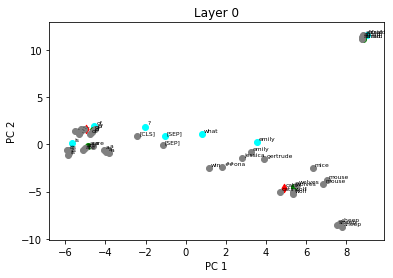

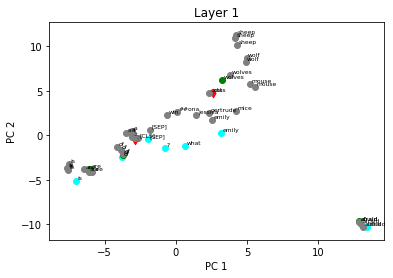

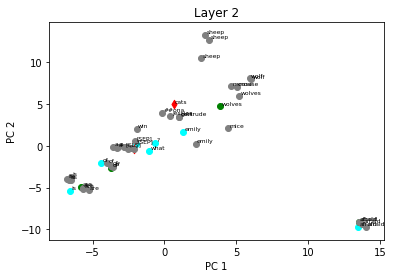

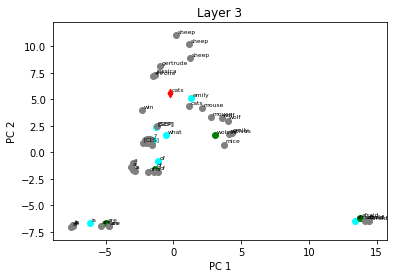

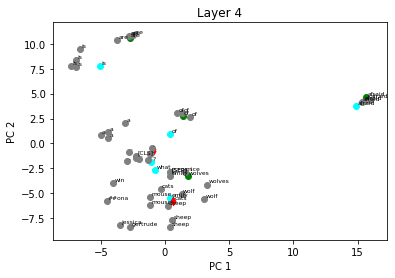

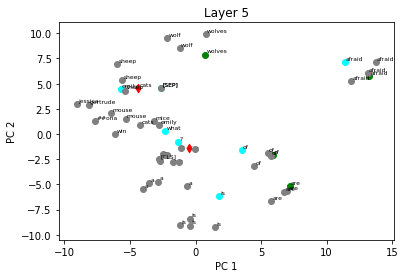

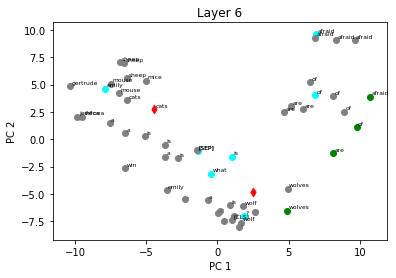

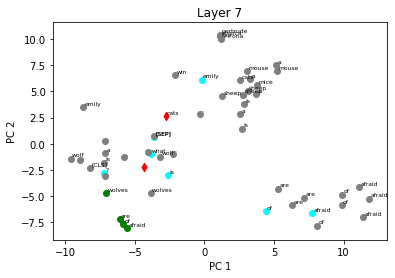

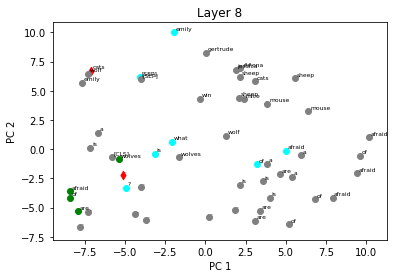

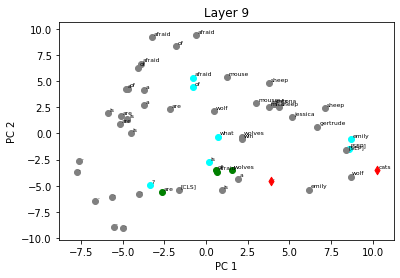

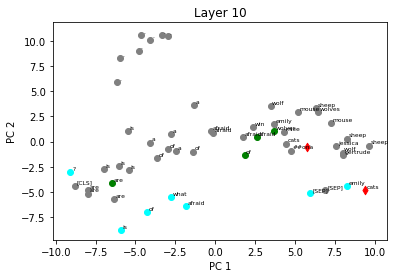

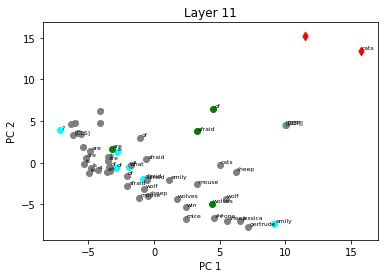

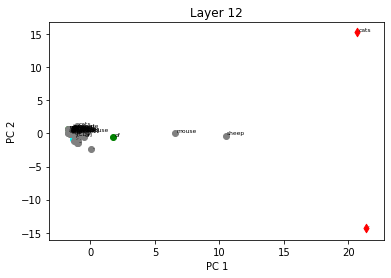

In [158]:
visualize_states(hstates, answer_index, question_index_range, support_facts_range)